In [55]:
from O.interface import *

In [2]:
from P3_JN_helper import P3_JN_helper

In [3]:
self = P3_JN_helper('SA')

succinic_acid


In [4]:
forms_model1 = [       'B',   'G'   ]
cells_model1 = [       '212', '211' ]

forms_model2 = ['A',   'B',   'G'   ]
cells_model2 = ['222', '222', '221' ]

forms_model3 = ['A',   'B',   'G'   ]
cells_model3 = ['223', '223', '321' ]

forms_model4 = ['A',   'B',   'G'   ]
cells_model4 = ['224', '224', '222' ]

form_groups = [forms_model1, forms_model2, forms_model3, forms_model4]
cell_groups = [cells_model1, cells_model2, cells_model3, cells_model4]

i = 1

forms = form_groups[i]
cells = cell_groups[i]
n_mol = self.list_n_mol[i]
_forms = [self.form_to_form[x] for x in forms]
nn = NN_interface_sc_multimap(
    name = f'{self.name}_300K_eqm_box_'+'_'.join(_forms)+'_'+'_'.join(cells),
     paths_datasets= [self.u_mean_by_form_nmol[(form,n_mol)]*n_mol for form in forms],
    running_in_notebook = True, training = False, #model_class = PGMcrys_v1,
    )

In [5]:
nn.load_model_(VERSION='P3')

molecule with 14 atoms, of which 8 are heavy atoms, and the rest are 6 hydrogens.
molecule with 14 atoms, of which 8 are heavy atoms, and the rest are 6 hydrogens.
molecule with 14 atoms, of which 8 are heavy atoms, and the rest are 6 hydrogens.
checking that ic_maps match the model:
self.n_att_heads: 2


2025-04-06 21:19:05.763428: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
nn.model.print_model_size()
#list(nn.model.shapes_trainable_weights)

There are 4266872 trainable parameters in this model, among 384 trainable weights.
[To see dimensionalities of the trainable weights print(list(self.shapes_trainable_weights)).] 


In [7]:
nn.evaluation_batch_size = 1000 # batch size for which model will be compiled in the next step (inverse direction)

In [8]:
%%time
# initial time while compiling (for the given batch size) (i.e., the first call of tf.function) : can be very slow

''' 
# unfortunately the sample model is compiled 3 times due to the crystal_index being different in 3 ways
# there might be a way to resove this in a later update, using something like this:

forward_graph_ = tf.function(forward_graph_, tf.funcion input_signature=[
                                    tf.TensorSpec(shape=[None,None,3], dtype=DTYPE_tf),
                                    tf.TensorSpec(shape=[], dtype=tf.int32)
                                    ]
                            )
inverse_graph_ = tf.function(inverse_graph_, tf.funcion input_signature=[
                                    tf.TensorSpec(shape=[None,None], dtype=DTYPE_tf),
                                    tf.TensorSpec(shape=[None,None,None], dtype=DTYPE_tf),
                                    tf.TensorSpec(shape=[], dtype=tf.int32)
                                    ]
                            )
# currently this gives error:
# TypeError: list indices must be integers or slices, not Tensor # error from idexing a list of objects nn.model.ic_maps[crystal_index]
                            
# further work: have only one ic_map because better to do temperatures (T) instead of Forms
#    'crystal index' -> T ; 'crystal encoding' -> 'temperature encoding'
#    The TypeError will dissapear, when temperature encoding is a continuous function of cast_32_(T), and no indexing involved.
'''

r_alpha = nn.sample_model_(20000,crystal_index=0)
r_beta = nn.sample_model_(20000,crystal_index=1)
r_gamma = nn.sample_model_(20000,crystal_index=2)

CPU times: user 58.5 s, sys: 3.73 s, total: 1min 2s
Wall time: 1min 9s


In [10]:
%%time
# time after compiled (for the given batch size):

r_alpha = nn.sample_model_(20000,crystal_index=0)
r_beta = nn.sample_model_(20000,crystal_index=1)
r_gamma = nn.sample_model_(20000,crystal_index=2)

CPU times: user 10.4 s, sys: 1.8 s, total: 12.2 s
Wall time: 17.8 s


In [11]:
r_alpha.shape, r_beta.shape, r_gamma.shape

((20000, 224, 3), (20000, 224, 3), (20000, 224, 3))

comparisons of samples from model in the r space (Cartesian space): 

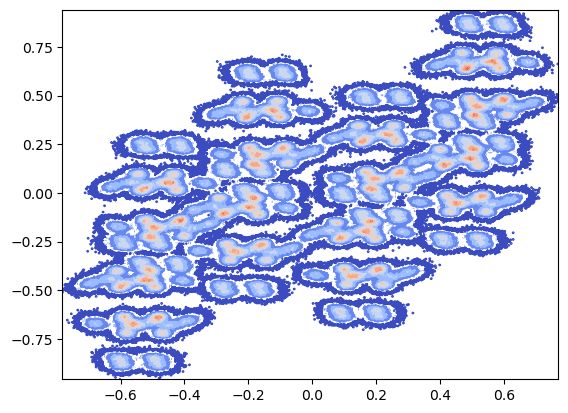

In [24]:
plot_2D_histogram_(r_alpha[...,0],r_alpha[...,2], bins=1000, cmap='coolwarm')

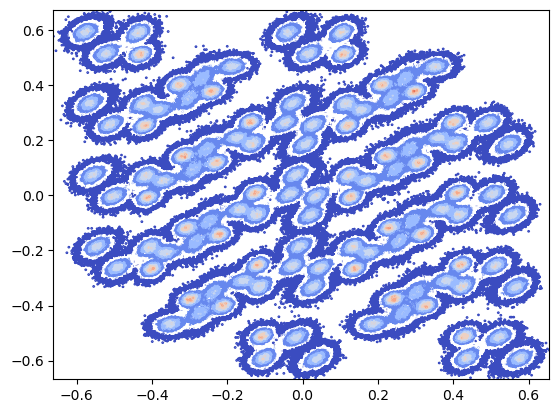

In [25]:
plot_2D_histogram_(r_beta[...,0],r_beta[...,2], bins=1000, cmap='coolwarm')

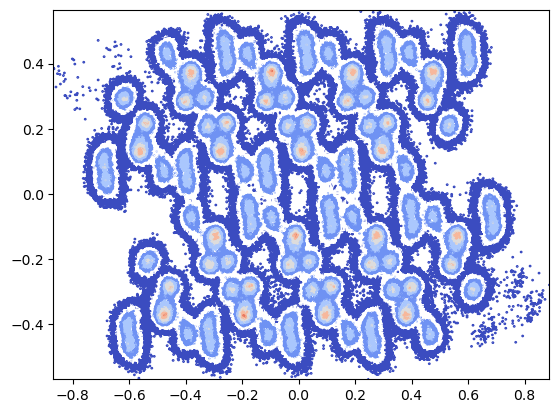

In [26]:
plot_2D_histogram_(r_gamma[...,0],r_gamma[...,2], bins=1000, cmap='coolwarm')

comparisons of samples from model in the x space of the model: [NB: z space is the same for the samples from model]

In [32]:
X_A, ladJrepf_A = nn.model.ic_maps[0].forward_(r_alpha)  ; xP_A, xC_A = [x.numpy() for x in X_A]
X_B, ladJrepf_B = nn.model.ic_maps[1].forward_(r_beta)   ; xP_B, xC_B = [x.numpy() for x in X_B]
X_G, ladJrepf_G = nn.model.ic_maps[2].forward_(r_gamma)  ; xP_G, xC_G = [x.numpy() for x in X_G]

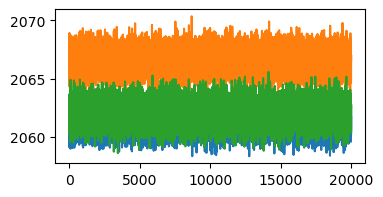

In [38]:
fig = plt.figure(figsize=(4,2))
plt.plot(ladJrepf_A)
plt.plot(ladJrepf_B)
plt.plot(ladJrepf_G)
# random plot ladJ of representation per point
plt.show()

In [46]:
xP_A.shape, xC_A.shape # same for *_B and *_G

((20000, 45), (20000, 16, 39))

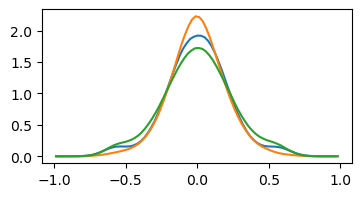

In [39]:
fig = plt.figure(figsize=(4,2))
plot_1D_histogram_(xC_A)
plot_1D_histogram_(xC_B)
plot_1D_histogram_(xC_G)
plt.show()

In [43]:
print(nn.model.periodic_mask)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0]


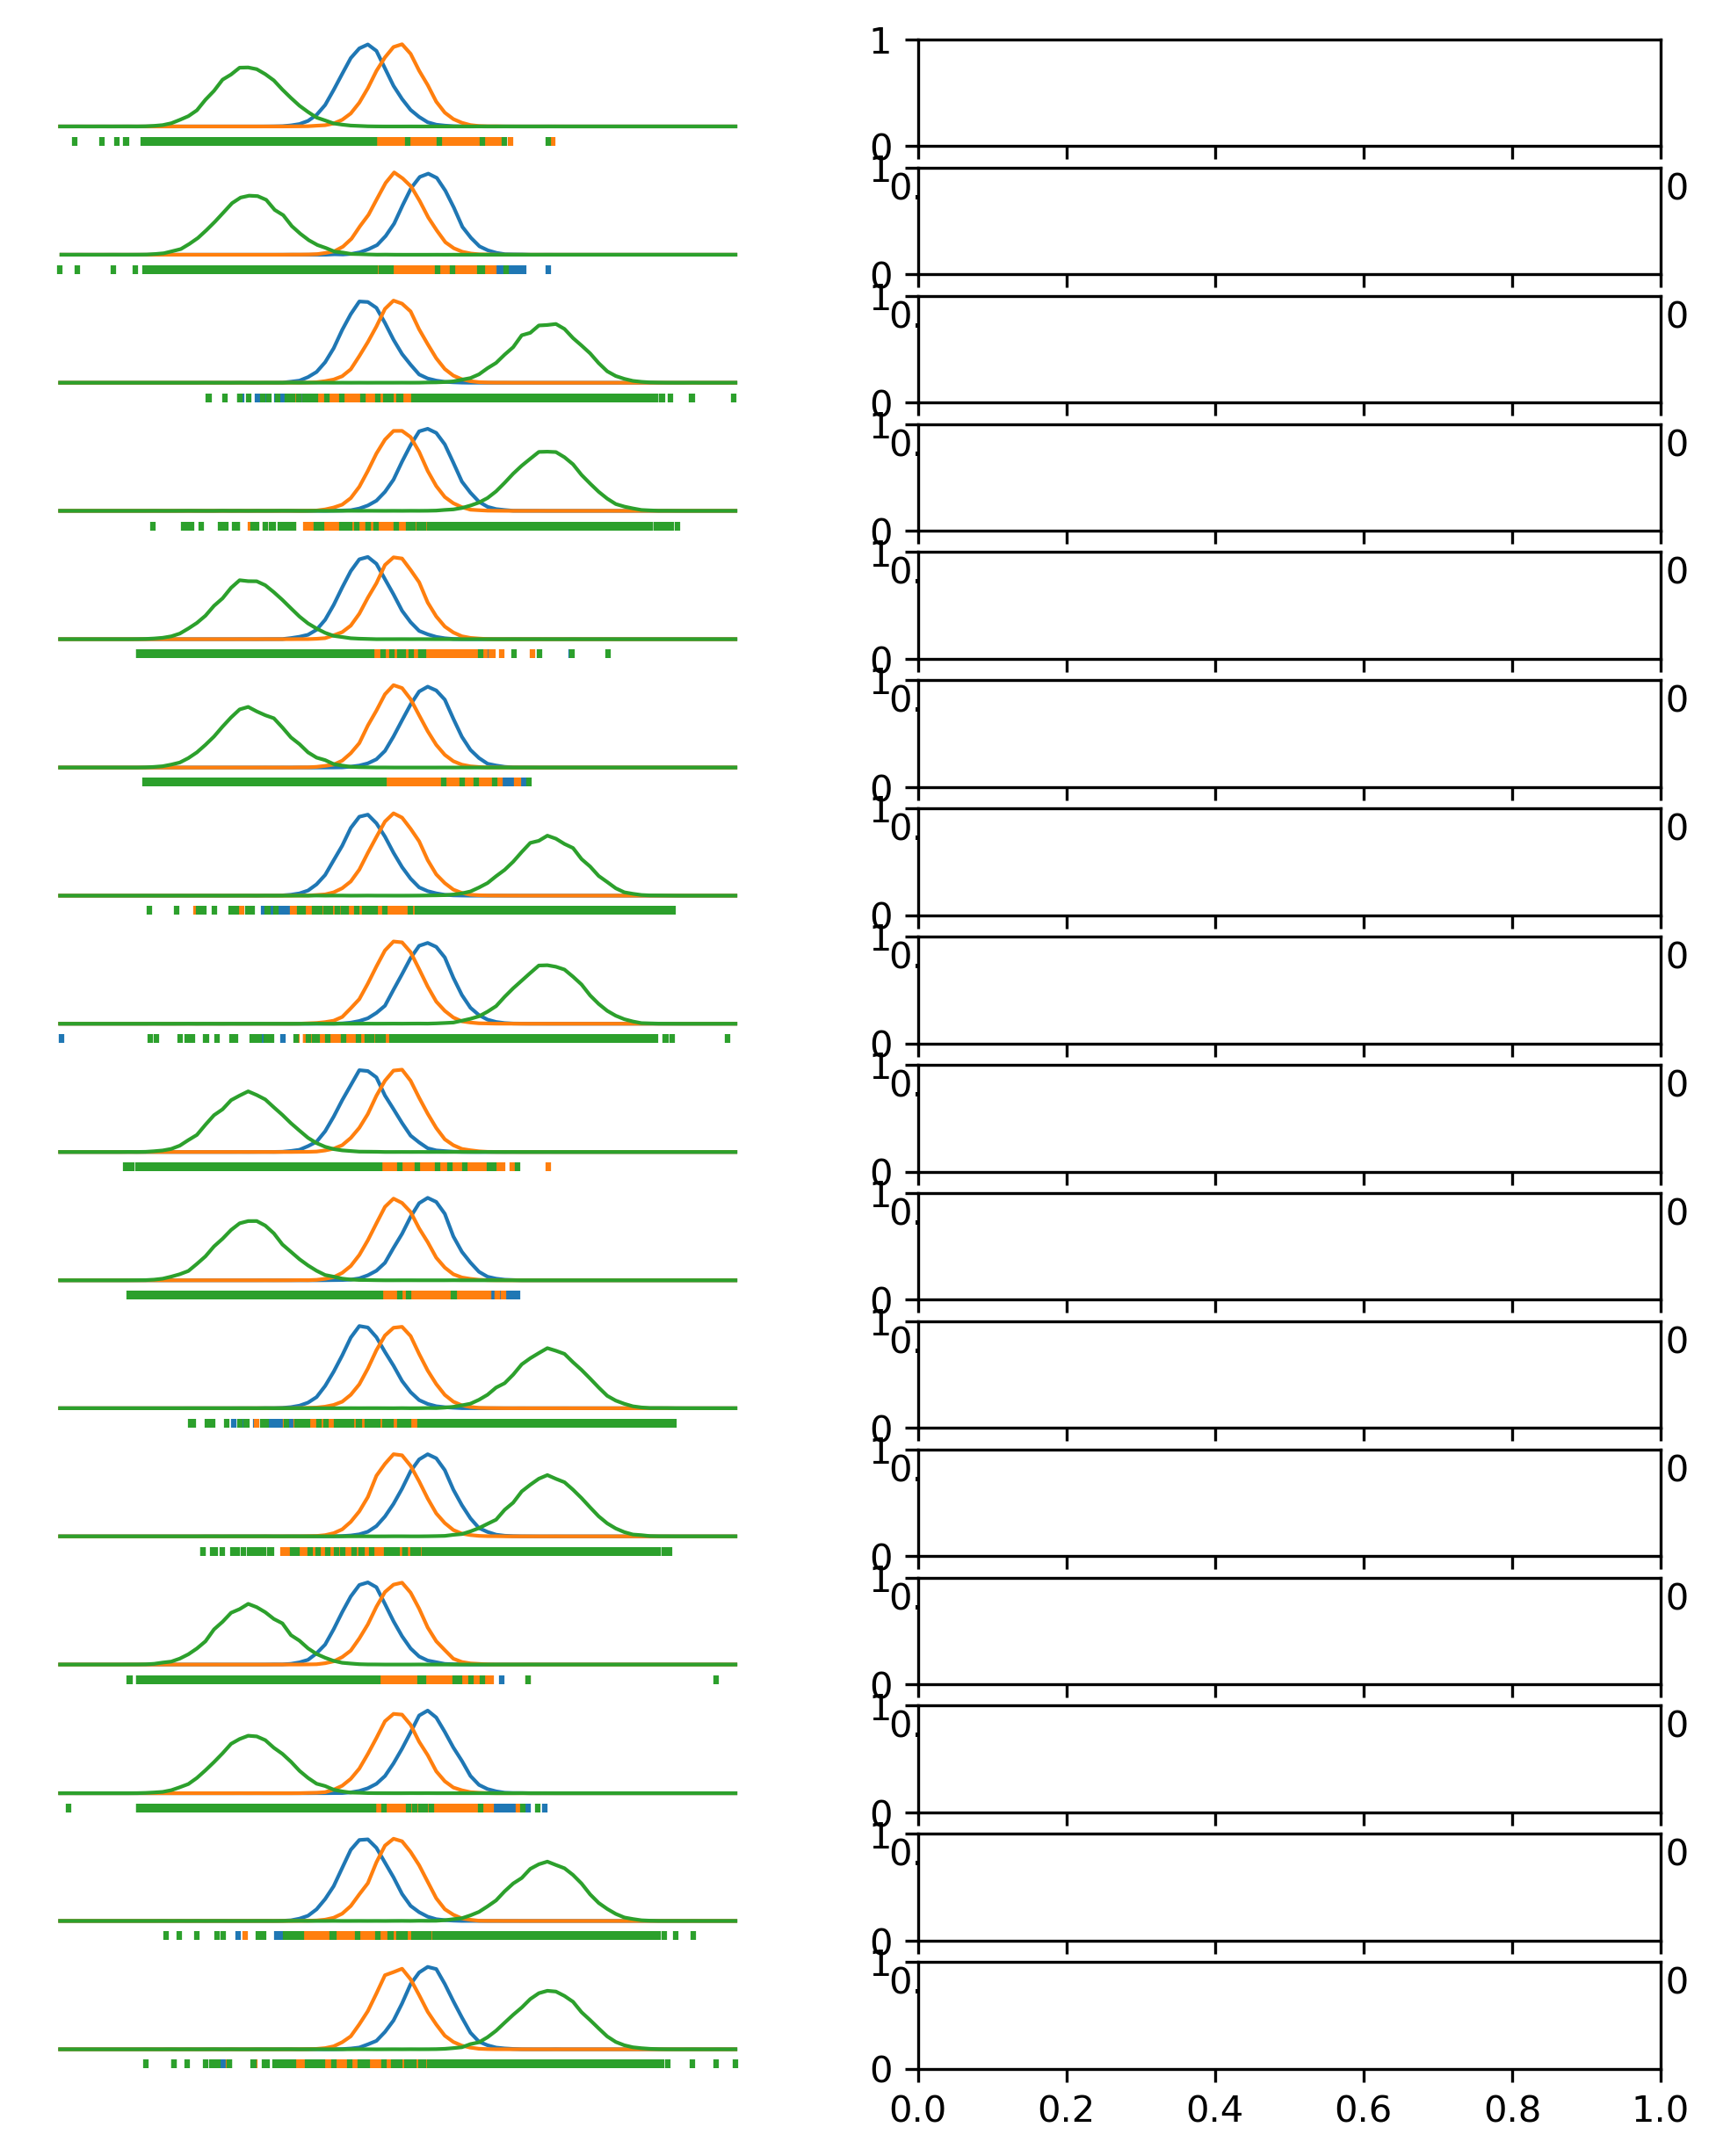

In [49]:
'''
[* MD data not available in this LITE version of the code]
plot showing that the model learned *correct/different 1D distributions for the single torsional angle that was not 'focused'
x_axis = n_mol different molecules in supercell (16 when loading with i = 1 in the 4th cell of the notebook)
y_axis = different torsional angles
colors = Forms
'''

n_mol = nn.model.n_mol
inds_periodic = np.where(nn.model.periodic_mask!=0)[0]
n_periodic = max(len(inds_periodic),2)
fig, ax = plt.subplots(n_mol, n_periodic, figsize=(10*0.8,10), dpi=300)

for ind_mol in range(n_mol):
    a = 0
    for ind_coor in inds_periodic:
        plot_1D_histogram_(xC_A[:,ind_mol,ind_coor], color='C0', ax=ax[ind_mol,a], bins=80, linewidth=1, range=[-1,1])
        plot_1D_histogram_(xC_B[:,ind_mol,ind_coor], color='C1', ax=ax[ind_mol,a], bins=80, linewidth=1, range=[-1,1])
        plot_1D_histogram_(xC_G[:,ind_mol,ind_coor], color='C2', ax=ax[ind_mol,a], bins=80, linewidth=1, range=[-1,1])

        show = xC_A[:,ind_mol,ind_coor].flatten().flatten()
        ax[ind_mol,a].scatter(show,[-1]*len(show), s=5, color='C0', marker='|')
        show = xC_B[:,ind_mol,ind_coor].flatten().flatten()
        ax[ind_mol,a].scatter(show,[-1]*len(show), s=5, color='C1', marker='|')
        show = xC_G[:,ind_mol,ind_coor].flatten().flatten()
        ax[ind_mol,a].scatter(show,[-1]*len(show), s=5, color='C2', marker='|')
    
        ax[ind_mol,a].set_xticks([])
        ax[ind_mol,a].set_yticks([])
        ax[ind_mol,a].axis('off')
        a+=1

FEs from the model:

In [50]:
nn.load_misc_()

In [51]:
nn.solve_BAR_using_pymbar_()

found saved BAR result
found saved BAR result
found saved BAR result


In [52]:
nn.load_energies_during_training_()

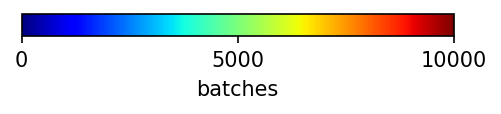

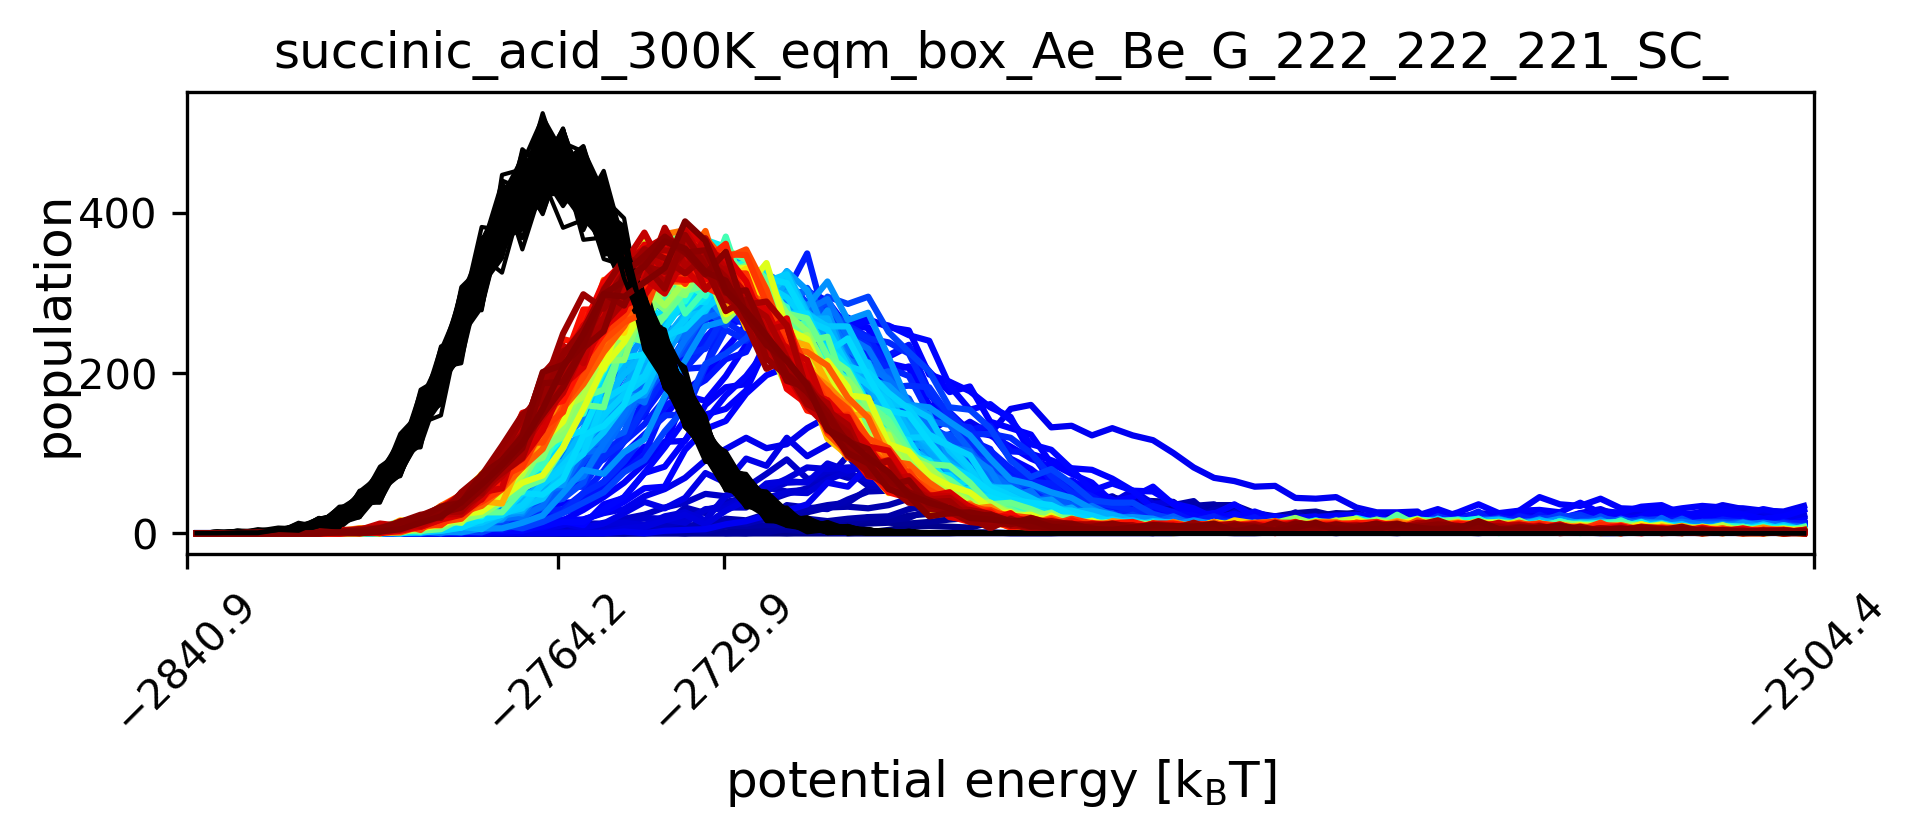

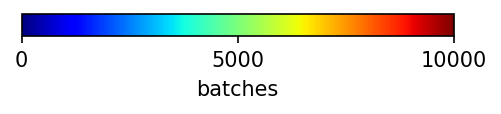

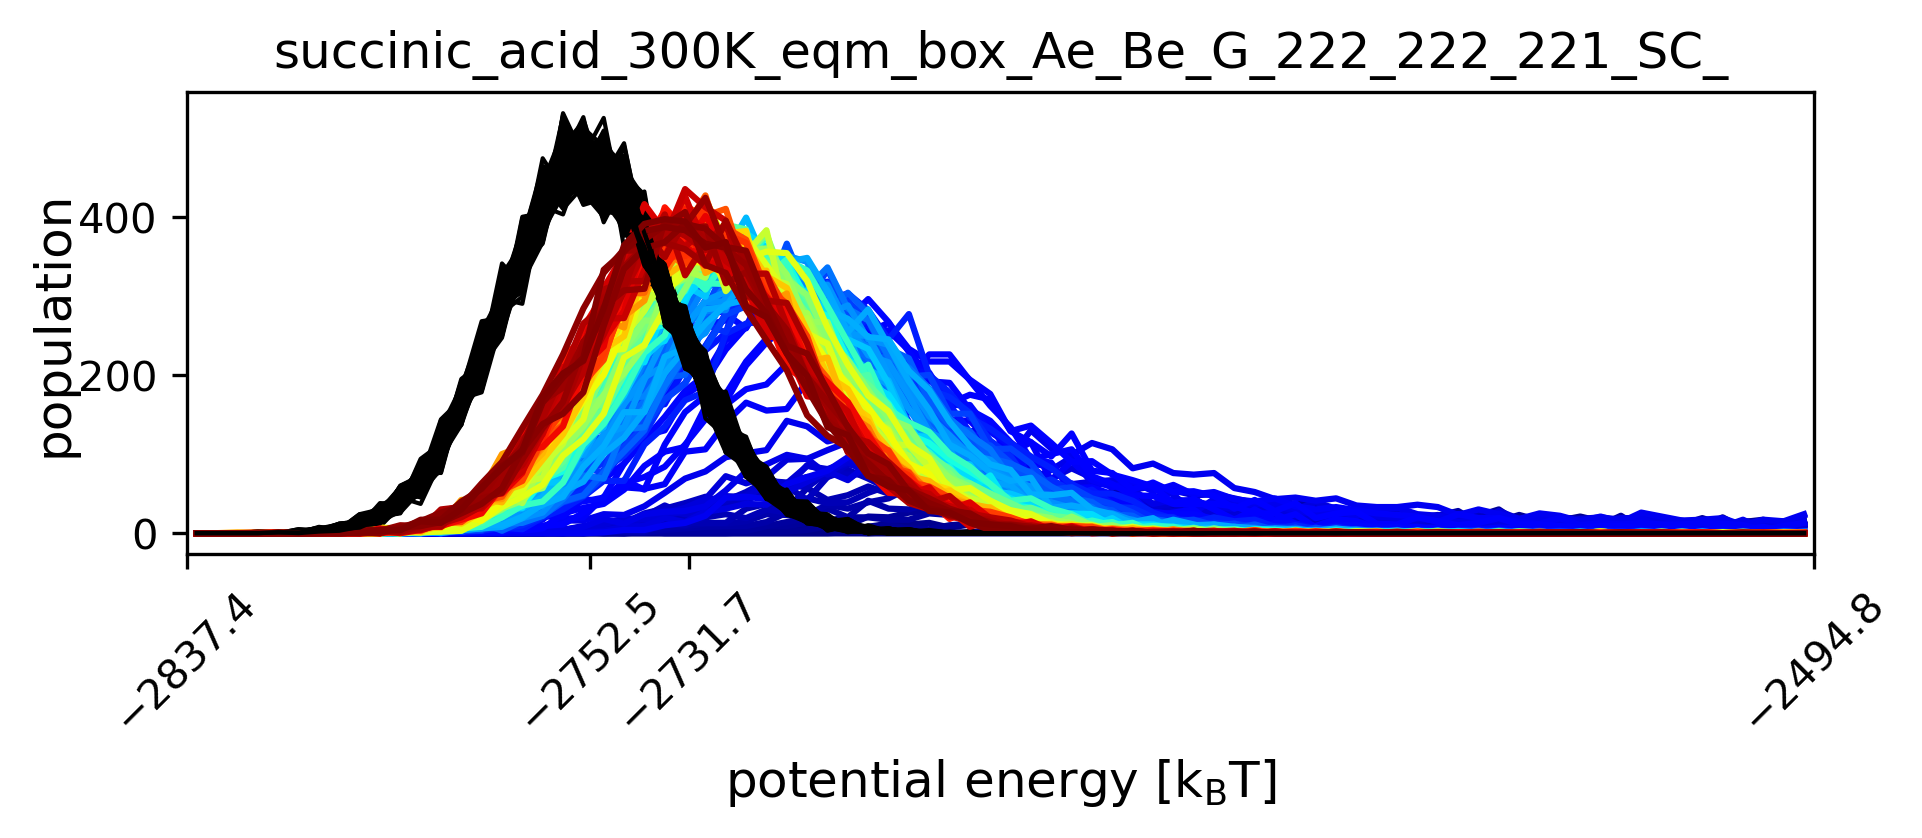

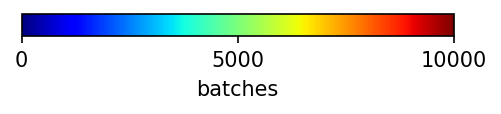

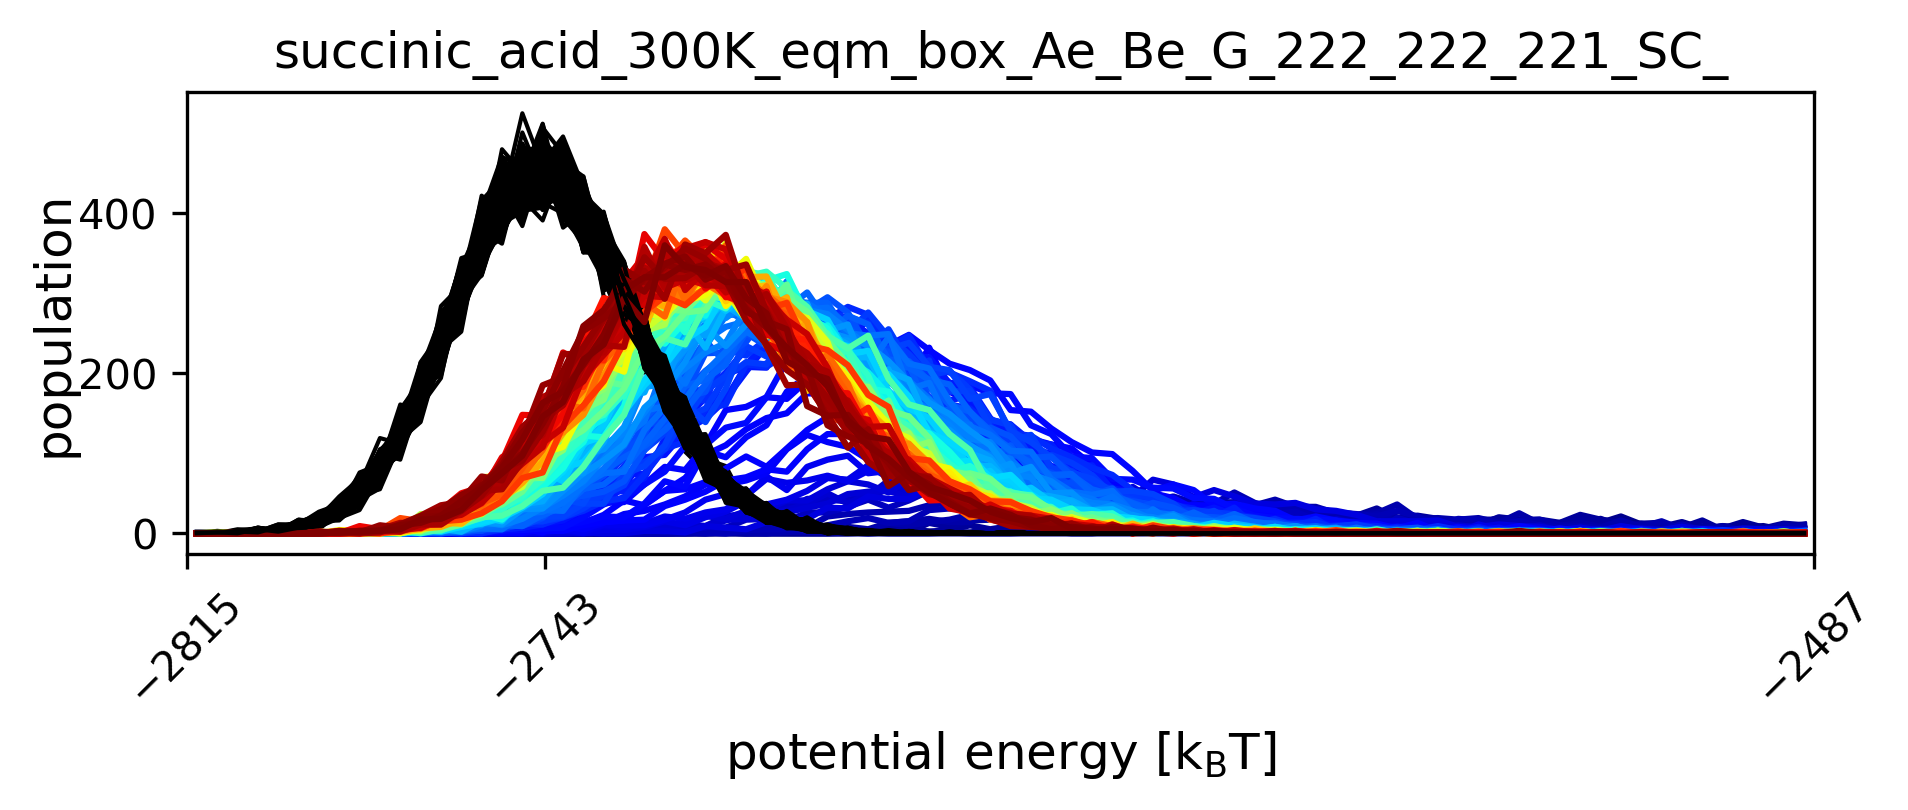

In [53]:
for crystal_indx in range(nn.n_crystals):
    nn.plot_energies_during_training_(crystal_index=crystal_indx)

-309.56403439459575 +/- 0.17853543289147283 final: -309.56403439438714 +/- 0.18218368224231798


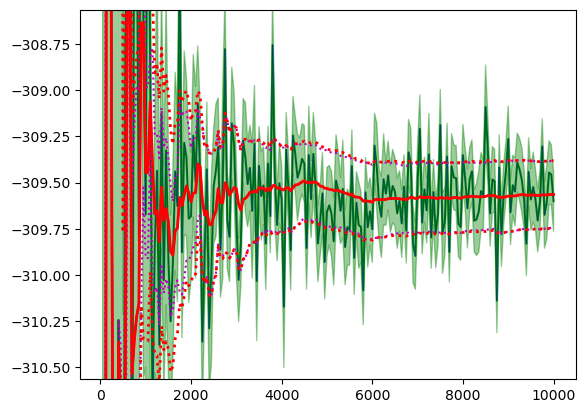

-301.25260164467 +/- 0.13171014372112722 final: -301.2526016439648 +/- 0.13617626949040018


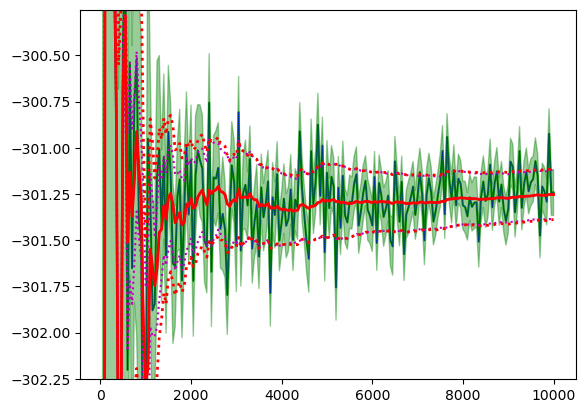

-300.65865895797174 +/- 0.2119147966879013 final: -300.6586589600819 +/- 0.22038269498819205


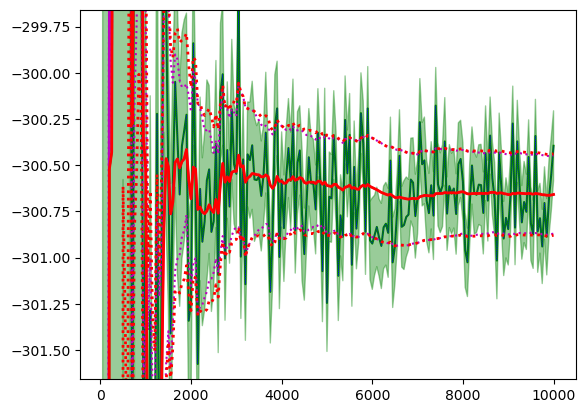

In [54]:
# 'red'   : averaged FE and averaged standard error
# 'm'     : averaged FE and averaged standard deviation
# 'green' : raw FE and raw standard error

for crystal_indx in range(nn.n_crystals):
    nn.plot_result_(crystal_indx)
    plt.show()